In [10]:
import os
import time
import numpy as np
import h3
import h3_turbo
import matplotlib.pyplot as plt
import psutil
import threading
import multiprocessing

# H3 Turbo Local Benchmark
This notebook benchmarks H3 Turbo (GPU) against a vectorized NumPy (CPU) baseline.
It runs locally without requiring Spark.

In [11]:
# --- Configuration ---
# Use 10M pings for local execution to fit in standard RAM.
# Increase to 50M or 100M if you have >32GB RAM.
N_PINGS = int(os.environ.get("H3_NUM_PINGS", 10_000_000))
N_ZONES = 100_000
RES_RAW = 9
RES_JOIN = 7

print(f"Benchmark Configuration:")
print(f"  Pings: {N_PINGS:,}")
print(f"  Zones: {N_ZONES:,}")

# Set License
if "H3_TURBO_LICENSE" in os.environ:
    h3_turbo.set_license_key(os.environ["H3_TURBO_LICENSE"])
else:
    print("WARNING: H3_TURBO_LICENSE not set. Benchmarks may fail.")

Benchmark Configuration:
  Pings: 10,000,000
  Zones: 100,000
License verified for: craig (Expires: 20260318)


In [12]:
# --- System Information ---
import subprocess

def get_gpu_name():
    """Gets the GPU name using nvidia-smi."""
    try:
        # Execute nvidia-smi to get the GPU name
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=gpu_name', '--format=csv,noheader'],
            capture_output=True,
            text=True,
            check=True
        )
        return result.stdout.strip()
    except (FileNotFoundError, subprocess.CalledProcessError) as e:
        print(f"Could not get GPU name via nvidia-smi: {e}")
        return "Unknown_GPU"

gpu_name = get_gpu_name()
print(f"Detected GPU: {gpu_name}")

Detected GPU: NVIDIA L4


In [13]:
# --- Data Generation ---
print("Generating Data...")
base_index = 0x8928308280fffff
k = 200
# Generate valid H3 indices using k-ring
pool = [h3.str_to_int(x) for x in h3.grid_disk(h3.int_to_str(base_index), k)]
pool_np = np.array(pool, dtype=np.uint64)

# Sample zones and pings
zones_np = np.random.choice(pool_np, N_ZONES, replace=(len(pool_np) < N_ZONES))
pings_np = pool_np[np.random.randint(0, len(pool_np), size=N_PINGS)]
print("Data Generation Complete.")

Generating Data...
Data Generation Complete.


In [14]:
# --- Helper: CPU Scramble Logic ---
def numpy_apply_weight(h3_array):
    """Vectorized CPU implementation of the scramble logic."""
    p = h3_array.astype(np.uint64)
    c1 = np.uint64(0xBF58476D1CE4E5B9)
    c2 = np.uint64(0x94D049BB133111EB)
    for _ in range(50):
        p ^= (p >> np.uint64(7)); p *= c1
        p ^= (p >> np.uint64(13)); p *= c2
        p ^= (p >> np.uint64(31))
    return p

def cpu_task_raw(chunk, res):
    parents = [h3.str_to_int(h3.cell_to_parent(h3.int_to_str(h), res)) for h in chunk]
    return numpy_apply_weight(np.array(parents, dtype=np.uint64))

def cpu_task_join(chunk, res, zone_set):
    parents = [h3.str_to_int(h3.cell_to_parent(h3.int_to_str(h), res)) for h in chunk]
    parents = numpy_apply_weight(np.array(parents, dtype=np.uint64))
    # Note: zone_set lookup is fast, but doing it in parallel helps
    return np.array([1 if p in zone_set else 0 for p in parents], dtype=np.uint8)

In [15]:
# --- Resource Monitoring ---
class ResourceMonitor:
    def __init__(self, interval=0.1):
        self.interval = interval
        self.running = False
        self.timestamps = []
        self.cpu_usage = []
        self.ram_usage = []
        self.thread = None
        self.start_time = None

    def _monitor(self):
        psutil.cpu_percent(interval=None) # Prime the CPU counter
        while self.running:
            self.timestamps.append(time.time() - self.start_time)
            self.cpu_usage.append(psutil.cpu_percent(interval=None))
            self.ram_usage.append(psutil.virtual_memory().percent)
            time.sleep(self.interval)

    def start(self):
        self.running = True
        self.start_time = time.time()
        self.thread = threading.Thread(target=self._monitor, daemon=True)
        self.thread.start()

    def stop(self):
        self.running = False
        if self.thread:
            self.thread.join()

print("\n--- Starting Resource Monitor ---")
monitor = ResourceMonitor(interval=0.2)
monitor.start()


--- Starting Resource Monitor ---


In [16]:
# --- Benchmark 1: Raw Compute (Transform) ---
print("\n--- Benchmark 1: Raw Compute (Transform) ---")

# GPU
print("Running GPU...")
h3_turbo.warmup()
start_gpu = time.time()
gpu_raw_results = h3_turbo.batch_transform(pings_np.copy(), RES_RAW)
raw_gpu_time = time.time() - start_gpu
print(f"GPU Time: {raw_gpu_time:.4f} s")

# CPU
print("Running CPU (Multiprocessing)...")
start_cpu = time.time()
num_workers = os.cpu_count()
chunk_size = (len(pings_np) + num_workers - 1) // num_workers
chunks = [pings_np[i:i + chunk_size] for i in range(0, len(pings_np), chunk_size)]

with multiprocessing.Pool(processes=num_workers) as pool:
    results = pool.starmap(cpu_task_raw, [(c, RES_RAW) for c in chunks])

cpu_raw_results = np.concatenate(results)
raw_cpu_time = time.time() - start_cpu
print(f"CPU Time: {raw_cpu_time:.4f} s")
print(f"Speedup: {raw_cpu_time / raw_gpu_time:.2f}x")


--- Benchmark 1: Raw Compute (Transform) ---
Running GPU...
GPU Time: 0.0403 s
Running CPU (Multiprocessing)...
CPU Time: 4.0970 s
Speedup: 101.79x


In [17]:
# --- Benchmark 2: Spatial Join ---
print("\n--- Benchmark 2: Spatial Join ---")

# GPU
print("Running GPU...")
start_gpu = time.time()
gpu_join_results = h3_turbo.spatial_join(pings_np, zones_np, RES_JOIN)
join_gpu_time = time.time() - start_gpu
matches_gpu = np.sum(gpu_join_results)
print(f"GPU Time: {join_gpu_time:.4f} s (Matches: {matches_gpu})")

# CPU
print("Running CPU (Set Lookup)...")
# Pre-calculate zone set (fair comparison)
zone_parents = numpy_apply_weight(np.array([h3.str_to_int(h3.cell_to_parent(h3.int_to_str(int(z)), RES_JOIN)) for z in zones_np], dtype=np.uint64))
zone_set = set(zone_parents)

start_cpu = time.time()
num_workers = os.cpu_count()
chunk_size = (len(pings_np) + num_workers - 1) // num_workers
chunks = [pings_np[i:i + chunk_size] for i in range(0, len(pings_np), chunk_size)]

with multiprocessing.Pool(processes=num_workers) as pool:
    results = pool.starmap(cpu_task_join, [(c, RES_JOIN, zone_set) for c in chunks])

cpu_join_results = np.concatenate(results)
join_cpu_time = time.time() - start_cpu
matches_cpu = np.sum(cpu_join_results)
print(f"CPU Time: {join_cpu_time:.4f} s (Matches: {matches_cpu})")
print(f"Speedup: {join_cpu_time / join_gpu_time:.2f}x")

monitor.stop()


--- Benchmark 2: Spatial Join ---
Running GPU...
GPU Time: 0.0627 s (Matches: 9999708)
Running CPU (Set Lookup)...
CPU Time: 4.5986 s (Matches: 9999708)
Speedup: 73.30x



--- Generating Plots ---
Saved performance plot to local_benchmark_performance_NVIDIA_L4.png


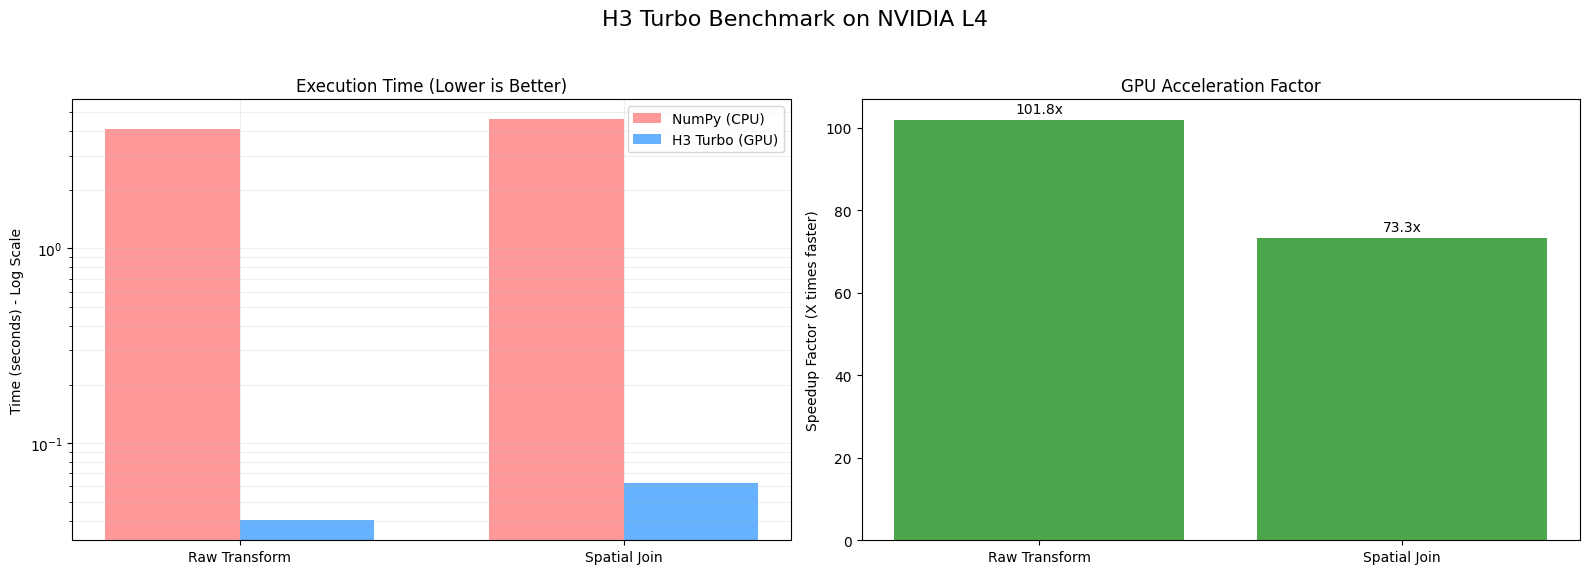

Plotting spatial sample of 10000 points...


AttributeError: module 'h3' has no attribute 'h3_to_geo'

In [18]:
# --- Visualization ---
print("\n--- Generating Plots ---")

# 1. Performance Comparison
tasks = ['Raw Transform', 'Spatial Join']
cpu_times = [raw_cpu_time, join_cpu_time]
gpu_times = [raw_gpu_time, join_gpu_time]

x = np.arange(len(tasks))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f"H3 Turbo Benchmark on {gpu_name}", fontsize=16)

# Plot 1: Execution Time
rects1 = ax1.bar(x - width/2, cpu_times, width, label='NumPy (CPU)', color='#FF9999')
rects2 = ax1.bar(x + width/2, gpu_times, width, label='H3 Turbo (GPU)', color='#66B2FF')

ax1.set_ylabel('Time (seconds) - Log Scale')
ax1.set_title('Execution Time (Lower is Better)')
ax1.set_xticks(x)
ax1.set_xticklabels(tasks)
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True, which="both", ls="-", alpha=0.2)

# Plot 2: Speedup Factor
speedups = [c / g for c, g in zip(cpu_times, gpu_times)]
bars = ax2.bar(tasks, speedups, color='green', alpha=0.7)
ax2.set_ylabel('Speedup Factor (X times faster)')
ax2.set_title('GPU Acceleration Factor')
ax2.bar_label(bars, fmt='%.1fx', padding=3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle

# Sanitize GPU name for filename
gpu_name_sanitized = "".join(c for c in gpu_name if c.isalnum() or c in (' ', '_')).rstrip().replace(' ', '_')
perf_filename = f'local_benchmark_performance_{gpu_name_sanitized}.png'
plt.savefig(perf_filename)
print(f"Saved performance plot to {perf_filename}")
plt.show()

# 2. Spatial Distribution Sample
sample_size = 10_000
print(f"Plotting spatial sample of {sample_size} points...")

pings_sample = np.random.choice(pings_np, sample_size, replace=False)
zones_sample = np.random.choice(zones_np, sample_size, replace=False)

# Convert H3 to Lat/Lon for plotting
pings_coords = np.array([h3.h3_to_geo(h3.int_to_str(h)) for h in pings_sample])
zones_coords = np.array([h3.h3_to_geo(h3.int_to_str(h)) for h in zones_sample])

plt.figure(figsize=(10, 10))
plt.scatter(pings_coords[:, 1], pings_coords[:, 0], c='blue', alpha=0.1, s=1, label='Pings')
plt.scatter(zones_coords[:, 1], zones_coords[:, 0], c='red', alpha=0.5, s=5, label='Hot Zones')
plt.title(f'Spatial Distribution (Sample of {sample_size}) on {gpu_name}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

spatial_filename = f'local_spatial_distribution_{gpu_name_sanitized}.png'
plt.savefig(spatial_filename)
print(f"Saved spatial plot to {spatial_filename}")
plt.show()

# 3. Resource Usage
plt.figure(figsize=(10, 6))
plt.plot(monitor.timestamps, monitor.cpu_usage, label='CPU Usage (%)', color='orange')
plt.plot(monitor.timestamps, monitor.ram_usage, label='RAM Usage (%)', color='purple')
plt.title(f'System Resource Usage during Benchmark on {gpu_name}')
plt.xlabel('Time (s)')
plt.ylabel('Usage (%)')
plt.legend()
plt.grid(True, alpha=0.3)

resource_filename = f'local_resource_usage_{gpu_name_sanitized}.png'
plt.savefig(resource_filename)
print(f"Saved resource usage plot to {resource_filename}")
plt.show()